# Info

In this notebook I am implementing a FaceRecognizer. The model is havelly based on the tutorial by machinelearningmastery.com.

The model uses:

* **Pretrained FaceNet model by Hiroki Taniai** 
* **Multi-Task Cascaded Convolutional Neural Network for face detection**

This work is a great exercise since it is almost a ready to deploy real world system.

**IMPORTANT: 
All pictures are private and I dont permit their spread. They were my experimentation on the real world.**

# Set Up

In [20]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import keras
from keras.models import load_model

import matplotlib.pyplot as plt
import PIL as Image
import cv2

from os import listdir

import mtcnn
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

# Get info about the data

In [36]:
from glob import glob
# Holding the paths:
train_path = 'data/train'
valid_path = 'data/val'

# useful for getting number of files
image_files = glob(train_path + '/*/*')
valid_image_files = glob(valid_path + '/*/*')

In [75]:
# Number of classes
# useful for getting number of classes
folders = glob(train_path + '/*')
K = len(folders)
folders = glob(valid_path + '/*')
K_valid = len(folders)
print('Number of train classes: {}'.format(K))
print('Number of valid classes: {}'.format(K))

Number of train classes: 5
Number of valid classes: 5


In [79]:
# Number of images in the different datasets
print('# Training Images {}'.format(len(image_files)))
print('# Validation Images {}'.format(len(valid_image_files)))

# Training Images 51
# Validation Images 26


In [84]:
print('Images per class in the train set:')
print()
for class_i in glob(train_path + '/*'):
    print('path {}'.format(class_i))
    k = len(glob(class_i + '/*'))
    print('Number of images {}'.format(k))
    print()

Images per class in the train set:

path data/train\angel
Number of images 5

path data/train\chavo
Number of images 11

path data/train\magi
Number of images 11

path data/train\roni
Number of images 9

path data/train\viki
Number of images 15



Take a look at some images

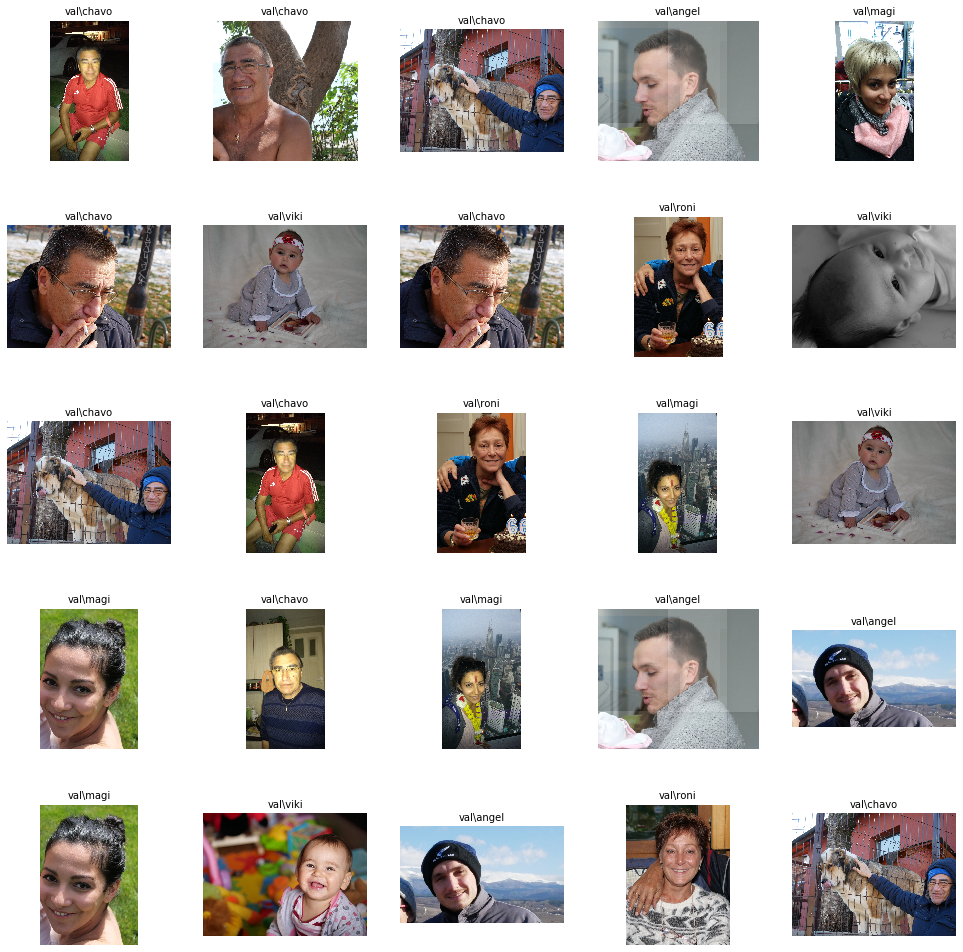

In [73]:
# Check the Training set
# Show some images from the training set
set_to_show = valid_path 
#valid_path #test_path #train_path

W_grid = 5
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel()

n_training = len(image_files)

for i in np.arange(0, W_grid*L_grid):
    
    folder_name = np.random.choice(glob(set_to_show + '/*'))
    pic = random_image = np.random.choice(glob(folder_name + '/*'))
    axes[i].imshow(plt.imread(pic))
    axes[i].set_title(folder_name.rsplit('/')[1], fontsize=10)
    axes[i].set_frame_on(True)
    axes[i].axis('off')
    
plt.subplots_adjust(hspace=0.4)

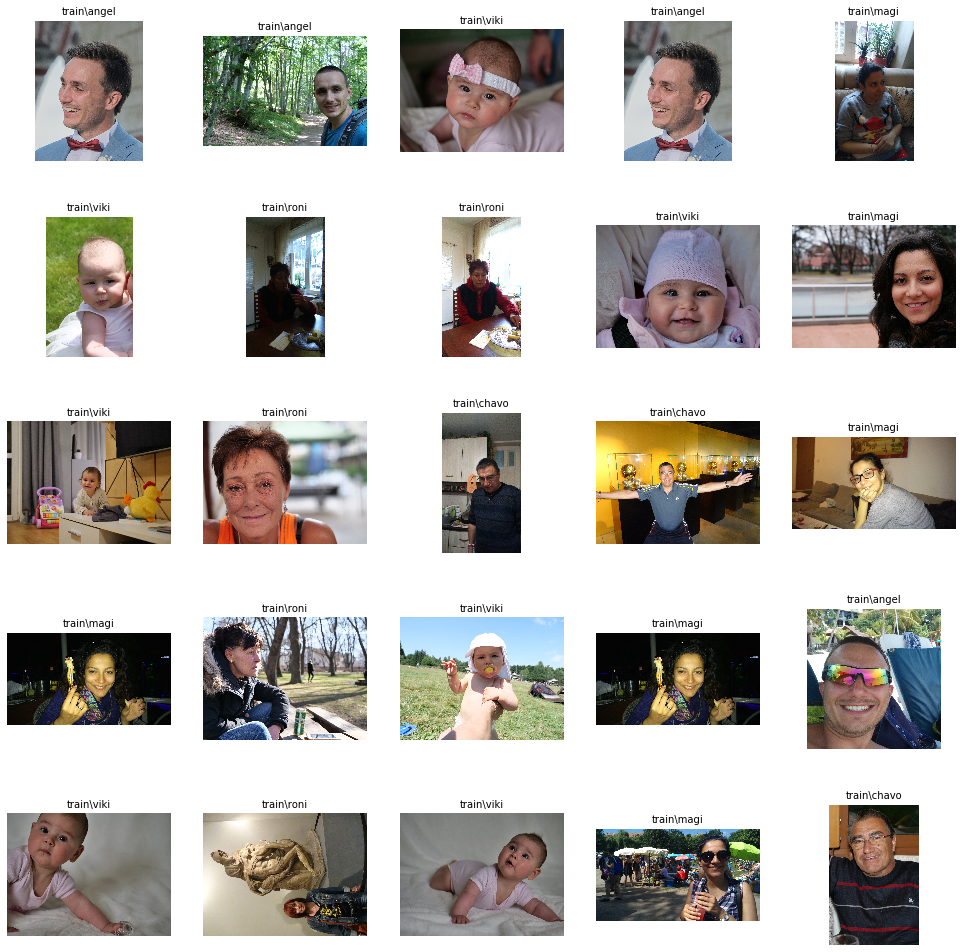

In [85]:
# Check the Training set
# Show some images from the training set
set_to_show = train_path 
#valid_path #test_path #train_path

W_grid = 5
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel()

n_training = len(image_files)

for i in np.arange(0, W_grid*L_grid):
    
    folder_name = np.random.choice(glob(set_to_show + '/*'))
    pic = random_image = np.random.choice(glob(folder_name + '/*'))
    axes[i].imshow(plt.imread(pic))
    axes[i].set_title(folder_name.rsplit('/')[1], fontsize=10)
    axes[i].set_frame_on(True)
    axes[i].axis('off')
    
plt.subplots_adjust(hspace=0.4)

# Loading and preprocessing the images

In [21]:
# Function to extract face and reshape in the form
def extract_face(filename, required_size=(160, 160)):
    img = cv2.imread(filename, 1)
    img = cv2.resize(img, (160, 160))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Create Detector using default weights
    detector = mtcnn.MTCNN()
    # detect face in the image
    result = detector.detect_faces(img)
    try:
        x1, y1, width, height = result[0]['box']
    except:
        x1, y1 = 0, 0
        width, height = img.shape[0], img.shape[1]
        
    # bug fix
    x1, y1 = abs(x1), abs(y1)

    # Calculate the two other points from the rectangle
    x2, y2 = x1 + width, y1 + height
    # Cut and resize
    face = img[y1:y2, x1:x2]
    face_array = cv2.resize(face, required_size)
    return face_array

# Extracting all faces from each directory into a list
def load_faces(directory):
    faces = []
    for filename in listdir(directory):
        path = directory + filename
        face = extract_face(path)
        faces.append(face)
    return faces

# Function to load the dataset
def load_dataset(directory):
    X = []
    y = []
    for subdir in listdir(directory):
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not listdir(path):
            continue
        faces = load_faces(path)
        labels = [subdir for i in range(len(faces))]
            # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        
        #Store the data
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [3]:
Xtrain, ytrain = load_dataset('data/train/')
Xtest, ytest = load_dataset('data/val/')
print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)

# Save the data
np.savez_compressed('ANGEL_dataset.npz', Xtrain, ytrain, Xtest, ytest)

>loaded 5 examples for class: angel
>loaded 11 examples for class: chavo
>loaded 11 examples for class: magi
>loaded 9 examples for class: roni
>loaded 15 examples for class: viki
>loaded 4 examples for class: angel
>loaded 5 examples for class: chavo
>loaded 6 examples for class: magi
>loaded 5 examples for class: roni
>loaded 6 examples for class: viki
(51, 160, 160, 3) (51,)
(26, 160, 160, 3) (26,)


# Encode the images

In [22]:
# Load model and weights
model = load_model('facenet_keras.h5')

c:\users\anspa\anaconda3\envs\tf20\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [23]:
# Get the encoding of 
def get_embeddings(model, image):
#     image.astype('float32') # I had this line missing
    mean, std = image.mean(), image.std()
    image = (image - mean) / std
    image = np.expand_dims(image, axis=0)
    emb = model.predict(image)
    
    return emb[0]

In [24]:
# Encode the training data
Xtrain_emb = []
for image in Xtrain:
    emb = get_embeddings(model, image)
    Xtrain_emb.append(emb)
Xtrain_emb = np.asarray(Xtrain_emb)

# Encode the test data
Xtest_emb = []
for image in Xtest:
    emb = get_embeddings(model, image)
    Xtest_emb.append(emb)
Xtest_emb = np.asarray(Xtest_emb)

# Save the embadings:
np.savez_compressed('ANGEL_dataset_embadings.npz', Xtrain_emb, ytrain, Xtest_emb, ytest)
print(Xtrain_emb.shape, Xtest_emb.shape)

(51, 128) (26, 128)


# Perform Face Classification

In [25]:
# Normalising the Encoding to have L2 Norm of 1
# needed since the vectors are compared by distance metrics
normalizer = Normalizer(norm='l2')
Xtrain_emb_norm = normalizer.transform(Xtrain_emb)
Xtest_emb_norm = normalizer.transform(Xtest_emb)

# Getting encodings for Y
le = LabelEncoder()
Ytrain = le.fit_transform(ytrain)
Ytest = le.transform(ytest)

# Making predictions with the SVC
cls = SVC(kernel='linear', probability=True)
cls.fit(Xtrain_emb_norm, Ytrain)
# predict Y_train, Y_test
Y_train_pred = cls.predict(Xtrain_emb_norm)
Y_test_pred = cls.predict(Xtest_emb_norm)

In [26]:
# Accuracy score
print('Train Accuaracy {}'.format(accuracy_score(Ytrain, Y_train_pred)))
print('Test Accuaracy {}'.format(accuracy_score(Ytest, Y_test_pred)))

Train Accuaracy 1.0
Test Accuaracy 0.9615384615384616


# Recognize a single picture

In [9]:
# Take a random image from the Test-Dataset
# and get the encoding

from random import choice
selection = choice([i for i in range(Xtest.shape[0])])
face = Xtest[selection]
face_emb = Xtest_emb[selection]
# get the y
random_face_name = ytest[selection]
random_face_class = le.transform([random_face_name])
print('Name {}, class {}, input shape {}'.format(random_face_name, 
                            random_face_class, face.shape))

Name viki, class [4], input shape (160, 160, 3)


Img shape (160, 160, 3)


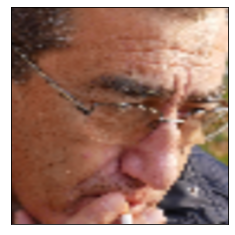

In [10]:
'''INSERT A CUSTOM IMAGE'''
# Inser a custom image
face = extract_face('data/val/chavo/P1060736.JPG')

# Take a look at the result
face = cv2.resize(face, (160, 160))
print('Img shape {}'.format(face.shape))
plt.imshow(face, interpolation='bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

# Get the encoding
face_emb = get_embeddings(model, face)

Text(0.5, 1.0, 'Predicted Name chavo with probability 87.90%')

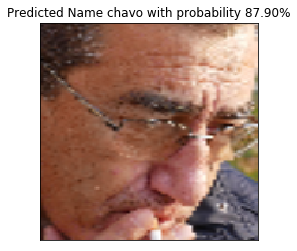

In [11]:
# Predict the image class:
img = np.expand_dims(face_emb, axis=0)
img = normalizer.transform(img)
yhat_class = cls.predict(img)
yhat_prob = cls.predict_proba(img)
# Result
predict_names = le.inverse_transform(yhat_class)[0]
certainty = yhat_prob[0, yhat_class][0]
# Print
plt.imshow(face)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.title('Predicted Name {0:} with probability {1:0.2f}%'.format(predict_names, certainty*100))

# Result and next steps

The result with ca. 96% accuracy is not bad at all. It is a classifier that classify images taken in different conditions - so its not the type of a system at an access point.

A next step would be for the model to recognize more than one face in an image and correctly put a bounding box around each one.

Also I might try to change the classification algorithm. Instead of using a linear SVC I would try to implement FaceRecognition based on the Trippled Loss as taught by Andrew Ng. Thus, a retraining of the model for each new person could be avoided.